#### 1. 30 days -> x days

Bibliography

- https://medium.com/analytics-vidhya/weather-forecasting-with-recurrent-neural-networks-1eaa057d70c3

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing

In [4]:
training_data = pd.read_csv("/home/roboto/Documents/GitHub/tutorials/data/weather/training.csv", sep = "\t")
testing_data  = pd.read_csv("/home/roboto/Documents/GitHub/tutorials/data/weather/testing.csv", sep = ",")
# l1, l2 = len(training_data), len(testing_data)
# min_max_scaler = preprocessing.MinMaxScaler()
# training_data['Temperature'] = min_max_scaler.fit_transform(training_data['Temperature'].values.reshape(l1, -1))
# testing_data['Temperature'] = min_max_scaler.fit_transform(testing_data['Temperature'].values.reshape(l2, -1))
print("Training")
print(training_data.head())
print("Testing")
print(testing_data.head())

Training
         Date  Temperature
0  01/01/2011         68.9
1  01/02/2011         66.4
2  01/03/2011         68.7
3  01/04/2011         71.4
4  01/05/2011         69.3
Testing
         Date  Temperature
0  09/03/2019         73.4
1  09/04/2019         71.6
2  09/05/2019         71.7
3  09/06/2019         71.6
4  09/07/2019         71.3


In [6]:
class WeatherTemperatureDataset(Dataset):
    def __init__(self, dataframe):
        super(WeatherTemperatureDataset, self).__init__()
        self.samples = []
        self.generate_samples(dataframe)
        
    def generate_samples(self, dataframe):
        series = dataframe['Temperature']
        n_days = 4
        for i in range(30, len(series) - n_days, 30):
            _input = torch.tensor(series[i - 30: i].values, dtype = torch.float)
            if True in torch.isnan(_input):
                pass
            else:
                _input = _input.reshape(-1, 1)
                target = torch.tensor(series[i:i+n_days].values, dtype = torch.float)
                self.samples.append((_input, target))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]
               

In [7]:
training_dataset = WeatherTemperatureDataset(training_data)
testing_dataset  = WeatherTemperatureDataset(training_data)

In [8]:
batch_size = 50
training_dataloader = DataLoader(training_dataset, shuffle = True, batch_size = batch_size, drop_last = True)
testing_dataloader = DataLoader(testing_dataset, shuffle = True)
sample = next(iter(training_dataloader))

In [9]:
sample[0].shape
# [batch_size, 30, 1]
# "batch_size" different sequences
# Each sequence has length 30 (30 days)
# Each element of the sequence is a - normalized - temperature

torch.Size([50, 30, 1])

In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, n_days):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        self.output = nn.Linear(hidden_size, n_days)
                            
        
    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = hidden[-1]
        out = self.output(out)
        
        return out, hidden
    
def train_rnn(model, dataloader, loss_function, optimizer, epochs, scheduler = None):
    epoch_losses = []
    mean = lambda xs : sum(xs)/len(xs) 
    for i in range(1, epochs+1):
        temp_losses = []
        for sample in dataloader: 
                optimizer.zero_grad()
                hidden = None
                
                inputs = sample[0]
                targets = sample[1]
                output, hidden = model(inputs, hidden)
                
                loss = loss_function(output, targets)
                temp_losses.append(loss.item())
#                 print(loss)
                loss.backward(retain_graph = True)
                optimizer.step()
                
        if scheduler != None:
            scheduler.step()
            
        epoch_losses.append(mean(temp_losses))
        if i%10 == 0:
            print('Epoch: {}/{}.............'.format(i, epochs), end=' ')
            print("Loss: {:.4f}".format(epoch_losses[-1]))
    
    return epoch_losses

In [11]:
model = RNN(1, 20, 1, 4)
# input_size (number of features) : 1 (temperature)
# hidden_size : 10
# num_layers : ??
criterion = nn.MSELoss()
lr = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 50, gamma=0.5)
epochs = 125

In [12]:
losses = train_rnn(model, training_dataloader, criterion, optimizer, epochs, scheduler)

Epoch: 10/125............. Loss: 3514.2310
Epoch: 20/125............. Loss: 1652.1920
Epoch: 30/125............. Loss: 573.8012
Epoch: 40/125............. Loss: 133.1151
Epoch: 50/125............. Loss: 28.5936
Epoch: 60/125............. Loss: 20.1572
Epoch: 70/125............. Loss: 13.4509
Epoch: 80/125............. Loss: 19.1990
Epoch: 90/125............. Loss: 22.6757
Epoch: 100/125............. Loss: 18.3181
Epoch: 110/125............. Loss: 21.2084
Epoch: 120/125............. Loss: 21.8306


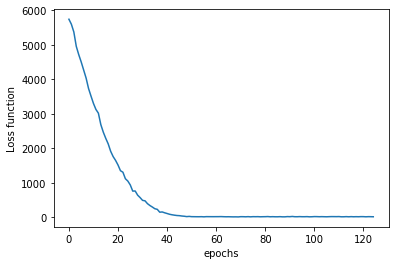

In [13]:
x_range = range(len(losses))
plt.plot(x_range, losses)
plt.xlabel("epochs")
plt.ylabel("Loss function")
plt.show()

In [14]:
def predict(series):
    model.eval()
    predictions, _ = model(series, None)
    return predictions

def compare(_input, target):
    values = lambda xs : [x.item() for x in list(xs[0])]
    prediction = predict(_input)
    loss = criterion(prediction, target).item()
    string = "Prediction: {}\nTarget: {}\nError: {}".format(values(prediction), values(target), loss)
    return string, loss

def test(test_dataloader):
    mean = lambda xs : sum(xs)/len(xs)
    losses = []
    for _input, target in test_dataloader:
        _, loss = compare(_input, target)
        losses.append(loss)
    
    return mean(losses)

In [15]:
test(testing_dataloader)

19.303921083919704